<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/speedup/lcmlora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LCM LoRA

Installation

In [ ]:
!pip install -q diffusers omegaconf transformers accelerate

Donwload Pretrained weights

In [ ]:
!wget https://huggingface.co/gsdf/Counterfeit-V3.0/resolve/main/Counterfeit-V3.0_fix_fp16.safetensors

Load model

In [ ]:
from diffusers import StableDiffusionPipeline, LCMScheduler
import torch

# パイプラインの準備
pipe = StableDiffusionPipeline.from_single_file(
    "/content/Counterfeit-V3.0_fix_fp16.safetensors",
    variant="fp16",
    torch_dtype=torch.float16,
).to("cuda")

# LoRAウェイトの準備
pipe.load_lora_weights("latent-consistency/lcm-lora-sdv1-5")

# スケジューラの準備
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

Inference with text2image



In [ ]:
%%time

# プロンプトの準備
prompt = "beautiful girl, super detailed, best quality"
negative_prompt = "worst quality, bokeh"

# 画像生成
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=4,
    guidance_scale=1,  # guide_scaleの無効化
    generator=torch.Generator("cpu").manual_seed(19),
).images[0]

# 画像の確認
display(image)

inference with Image2Image

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline, LCMScheduler
import torch

# パイプラインの準備
pipe = StableDiffusionImg2ImgPipeline.from_single_file(
    "/content/Counterfeit-V3.0_fix_fp16.safetensors",
    variant="fp16",
    torch_dtype=torch.float16,
).to("cuda")

# LoRAウェイトの準備
pipe.load_lora_weights("latent-consistency/lcm-lora-sdv1-5")

# スケジューラの準備
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

In [ ]:
!wget https://www.toho-ent.co.jp/wp-content/uploads/2021/10/2021-10-27_09-59-50_225736-1024x682.jpg -O /content/nagasawa.jpg

In [ ]:
%%time
from PIL import Image

# プロンプトの準備
prompt = "beautiful girl, super detailed, best quality"
negative_prompt = "worst quality, bokeh"
init_image = Image.open("/content/nagasawa.jpg").convert("RGB")

# 画像生成
image = pipe(
    prompt=prompt,
    image=init_image,
    negative_prompt=negative_prompt,
    num_inference_steps=4,
    guidance_scale=1,  # guide_scaleの無効化
    generator=torch.Generator("cpu").manual_seed(19),
    strength=0.5
).images[0]

# 画像の確認
display(image)

Inference with ControlNet

In [2]:
!pip install -q controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.4/202.4 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.5 MB/s eta 0:00:00


In [ ]:
from controlnet_aux import OpenposeDetector
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, DDIMScheduler

# ControlNetモデルの準備
controlnet_pose = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_openpose",
    torch_dtype=torch.float16
).to("cuda")


openpose_detector = OpenposeDetector.from_pretrained("lllyasviel/Annotators")

pipe = StableDiffusionControlNetPipeline.from_single_file(
    "Counterfeit-V3.0_fix_fp16.safetensors",
    controlnet=[controlnet_pose],
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

# LoRAウェイトの準備
pipe.load_lora_weights("latent-consistency/lcm-lora-sdv1-5")


  0%|          | 0/4 [00:00<?, ?it/s]

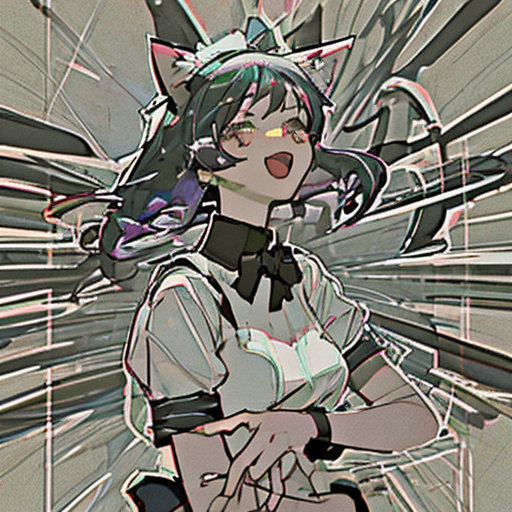

In [5]:
# コントロール画像の準備
from PIL import Image
init_image = Image.open("/content/nagasawa.jpg").convert("RGB")
init_image = init_image.resize((512, 512))
openpose_image = openpose_detector(init_image)

# 画像生成
image = pipe(
    "cute cat ear maid dancing, super detailed, best quality",
    negative_prompt="(worst quality:1.4), (low quality:1.4), (monochrome:1.3)",
    num_inference_steps=4,
    guidance_scale=1,
    generator=torch.Generator(device="cpu").manual_seed(123),
    image=[openpose_image],
).images[0]

# 確認
display(image)